# **RECONNAISSANCE DE FACE**
- Nom :GHOUL
- Prenom : Branis
- id : 28612738

L'objectif de cette session pratique est de de créer un réseaux de neurones convolutif (CNN) de base, d'évaluer ses résultats et de comparer avec un autre réseau pré-entraîné plus grand (Resnet50). Nous utilisons le jeu de données `Labelled Faces in the Wild (LFW)`, une référence publique pour la vérification des visages, que nous utilisons ici comme jeu de données de classification en ajoutant la contrainte que chaque individu possède plus de 70 images représentatives. Nous obtenons ainsi un jeu de données contenant 7 classes : $$\text{['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'].}$$

### **importation des librairies nécessaires**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.datasets import fetch_lfw_people
import torchvision.utils
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import optim
from collections import defaultdict
from IPython.display import clear_output
from pdb import set_trace as bp

### **Fonctions utiles**

In [3]:
def imshow(img):
    if len(img.shape)==3:
        plt.imshow(img[0], cmap = "gray", vmin=0, vmax=1)
    else:
        plt.imshow(img, cmap = "gray", vmin=0, vmax=255)
    plt.show()    

def live_plot(data_dict, figsize=(7,5), title=''):
    """function for sequentially updating a plot"""
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()

def reordering(targets, n_classes):
    """function taking 
    targets = [3,0,2,1,1,0,3,0,3,2,2,1,2,2,0]
    and producing the permutation perm that gives the ordering
    targets[perm] = [0,1,2,3,0,1,2,3,0,1,2,3,0,2,2].
    It can be useful to create perfectly balanced val and test sets,
    as it is enough to take the beginning of the permuted dataset.
    """
    indices_per_class = defaultdict(list)
    for e,t in enumerate(targets):    
        indices_per_class[t].append(e)
    n_max_class = max([len(l) for l in indices_per_class.values()])
    perm = []
    for i in range(n_max_class):
        for t in range(n_classes):
            try:
                perm.append(indices_per_class[t][i])
            except:
                continue
    assert len(perm) == len(targets)
    return perm


def show_images(images, targets, nb_samples_of_each_individual=4, grid=False, figsize=(30, 20)):
    """  
    showing images as grid, 
    images : Image dataset
    targets : Images labels
    nb_samples_of_each_individual : Number of samples of each individual
    grid : Boulen indicating whether the figure will be in grid mode or not  
    total_cols : Desired number of columns
    figsize : The dimensions of the figure 
    """
    assert len(images) > 0
    assert len(targets) == len(images)
    assert isinstance(images[0], np.ndarray)

    # Number of classes.
    n_classes = len(np.unique(targets))
    # Number total of images.
    nb_toltal_images = nb_samples_of_each_individual * n_classes
    
    # compute number of cols & row. 
    total_cols    = min(nb_toltal_images, nb_samples_of_each_individual)
    total_rows    = int(nb_toltal_images / total_cols) + (1 if nb_toltal_images % total_cols != 0 else 0)

    arg_indexes = np.array([np.argwhere(targets == label)[:nb_samples_of_each_individual] for label in range(n_classes)]).flatten()

    # Create a grid of subplots.
    fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]
    # it will helps to show total images as grid.
    for ax, arg_index in zip(range(len(list_axes)), arg_indexes):
        img    = images[arg_index]
        list_axes[ax].imshow(img, cmap='gray')
        list_axes[ax].grid(grid)
        list_axes[ax].set_axis_off()
        list_axes[ax].set_title(f'label {targets[arg_index]}')

    for i in range(nb_toltal_images, len(list_axes)):
        list_axes[i].set_visible(False)


def show_images_and_pridiction(net, best_checkpoint, images, labels, target_names, inference, total_cols=4, grid=False, figsize=(30, 20)):

    nb_images = len(images)
    # compute number of cols & row  
    total_cols    = min(nb_images, total_cols)
    total_rows    = int(nb_images / total_cols) + (1 if nb_images % total_cols != 0 else 0)
    # Create a grid of subplots.
    fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)
    # Create list of axes for easy iteration.
    Net = net()
    Net.load_state_dict(best_checkpoint)
    Net.eval()
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]
    # it will helps to show total images as grid 
    for image, label, i in zip(images, labels, range(len(list_axes))):
        pred = inference(net=Net, image=image)
        list_axes[i].imshow(image[0][0], cmap='gray')
        list_axes[i].grid(grid)
        list_axes[i].set_axis_off()
        list_axes[i].set_title(f'{target_names[pred]}', fontsize=10, color= ('green' if pred==label else 'red'), fontweight='bold')

    for i in range(nb_images, len(list_axes)):
        list_axes[i].set_visible(False)


def metrics(y, y_pred):
  assert len(y) == len(y_pred)
  labels = sorted(np.unique(y))
  # Accuracy score.
  accuracy  = (y == y_pred).astype(int).sum()/len(y)
  # Precision score and recall score.
  precision = recall = f1_score = []
  for i, label in enumerate(labels) :
    precision.append((y[np.argwhere(y_pred==label)] == y_pred[np.argwhere(y_pred==label)]).astype(int).sum() / y_pred[np.argwhere(y_pred==label)].astype(int).sum())
    recall.append((y[np.argwhere(y_pred==label)] == y_pred[np.argwhere(y_pred==label)]).astype(int).sum() / y[np.argwhere(y==label)].astype(int).sum())
    f1_score.append(2 / (1/precision[-1] + 1/recall[-1]))
  return (accuracy, precision, recall, f1_score)


def inference(net, image):
    inf = net(image)
    softmax = nn.Softmax(dim=1)
    Output = softmax(inf)

    return np.argmax(Output.detach().numpy())




### **GESTION DE DATASET**

In [4]:
class LFW(Dataset):
    def __init__(self, min_faces_per_person=70, sub_set='all', transform=None):
        assert sub_set in ['all', 'train', 'test', 'val'], (f'sub_set {sub_set} is not supported.')

        self.sub_set = sub_set
        # transformation for dataaug 
        self.transform = transform
        # lfw_people, automatic download
        self.lfw_people = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=1)
        # samples (images and target labels)   
        self.target_names = self.lfw_people.target_names  
        self.n_classes = self.target_names.shape[0]
        self.images, self.targets = self.creating_dataset(min_faces_per_person)
  
        # extra info
        self.n_samples, self.h, self.w = self.images.shape
        
        assert self.n_samples == len(self.targets)

      
    def creating_dataset(self, min_faces_per_person):
        # getting recodering indexes
        reord = reordering(self.lfw_people.target, n_classes=self.n_classes)
        # Checking sub_set. 
        if self.sub_set == 'train':
          indexes = reord[2*min_faces_per_person:]
        elif self.sub_set == 'test':
          indexes = reord[:min_faces_per_person]
        elif self.sub_set == 'val':
          indexes = reord[min_faces_per_person:2*min_faces_per_person]
        else:
          indexes = reord

        return (np.array([self.lfw_people.images[i] for i in indexes]), 
               np.array([self.lfw_people.target[i] for i in indexes]))
        
    def get_info(self):
      print(f'#------------- {self.sub_set} datest -------------#')
      print(f'The number of images         : {len(self.images)}')
      print(f'The number of targets        : {len(self.targets)}')
      print(f'The number of classes        : {self.n_classes}')
      print(f'The names of each individual : {self.target_names}')
      print(f'Image dimensions             : {self.images.shape}')


    def __getitem__(self,index):
        """
        Returns an image and a label
        """
        if index >= self.__len__():
            raise IndexError('list index out of range')
        target = self.targets[index]
        img = self.images[index].astype(np.uint8)

        if self.transform is not None:
            img = self.transform(img)
        return img, target
    
    def __len__(self):
        return self.n_samples

### **Modèles de réseaux neurones**

In [5]:
class ConvNet(nn.Module):
    """Basic ConvNet Conv(1, 32, 64) -> FC(100, 7) -> softmax."""
    def __init__(self, in_channels=1, n_outputs=7):
        super(ConvNet, self).__init__()

        # CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels, 96, kernel_size=11,stride=4),       # H=W=100 -> floor(1+(100-11)/4) = 23
            nn.ReLU(inplace=True),                           
            nn.MaxPool2d(3, stride=2),                       # 23 -> floor(1+(23-3)/2) = 11
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),     # 11 -> floor(1+(11-5)/1) = 7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),                       # 7 -> floor(1+(7-2)/2) = 3
            
            nn.Conv2d(256, 384, kernel_size=3,stride=1),     # 3 -> floor(1+(3-3)/1) = 1
            nn.ReLU(inplace=True)
        )

        # Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,n_outputs)
        )

    def forward(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output


class Resnet18(nn.Module):
    """ResNet 18, pretrained, with one input chanel and 7 outputs."""
    def __init__(self, in_channels=1, n_outputs=7):
        super(Resnet18, self).__init__()

        # self.model = torchvision.models.resnet18()
        self.model = torchvision.models.resnet18(pretrained=True)

        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2,
                                     padding=3, bias=False)

        # Last layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, n_outputs)

    def forward(self, x):
        return self.model(x)

### **La boucle d'entrainement**

In [6]:
def train_loop(train_dataloader, val_data, Net, metrics, Loss, 
               lr=0.0005,
               n_epoch=50):
    """A simple train loop"""

    # val dataloader
    val_dataloader = DataLoader(val_data)

    # init plots
    to_plot = {'train loss': [], 'val loss': [], 'val accuracy': []}

    # net and optim
    gpu = torch.cuda.device_count()
    if gpu:
        print('using GPU')
        net = Net().cuda()
    else:
        print('using CPU')
        net = Net()
    optimizer = optim.Adam(net.parameters(), lr = lr, weight_decay=1e-3)

    # checkpoint
    best_checkpoint = {'val accuracy' : 0, 'epoch': 0, 'checkpoint' : None}

    # Iterate throught the epochs
    for epoch in range(n_epoch):

        # init loss recording
        train_losses = []

        # put the net on train mode
        net.train()

        # Iterate over batches
        for img, label in train_dataloader:

            # Send the images and labels to CUDA
            if gpu:
                img, label = img.cuda(), label.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output = net(img)

            # Pass the outputs of the networks and label into the loss function
            train_loss = Loss(output, label)

            # Calculate the backpropagation
            train_loss.backward()

            # Optimize
            optimizer.step()

            # record train loss
            with torch.no_grad():
                train_losses.append(train_loss.item())
        
        with torch.no_grad():
            to_plot['train loss'].append(np.mean(train_losses))

            # validation
            val_records = {'gt': [], 'pred': []}
            val_losses = []
            net.eval()
            for img, label in val_dataloader:
                if gpu:
                    img, label = img.cuda(), label.cuda()
                output = net(img)
                val_losses.append(Loss(output,label).item())
                val_records['gt'].append(int(label.cpu()))
                val_records['pred'].append(int(torch.argmax(output,1).cpu()))
            to_plot['val loss'].append(np.mean(val_losses))

            # metrics
            accuracy, precision, recall, f1_score = metrics(np.array(val_records['gt']),np.array(val_records['pred']))
            to_plot['val accuracy'].append(accuracy)

        # plots
        live_plot(to_plot)

        # checkpoint selection via validation    
        if best_checkpoint['val accuracy']<accuracy:
            best_checkpoint['val accuracy'] = accuracy
            best_checkpoint['epoch'] = epoch
            best_checkpoint['checkpoint'] = net.state_dict()
        
    print(f"checkpoint generated from epoch {best_checkpoint['epoch']}, with val accuracy {best_checkpoint['val accuracy']}")
    return best_checkpoint['checkpoint']

### 0. Récupération du jeu de données de `Labelled Faces in the Wild (LFW)` pour la visualisation 

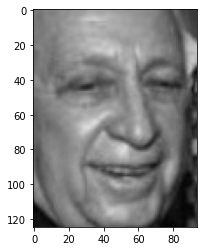

#------------- all datest -------------#
The number of images         : 1288
The number of targets        : 1288
The number of classes        : 7
The names of each individual : ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Image dimensions             : (1288, 125, 94)


In [7]:
LFW_vis = LFW(min_faces_per_person=70, sub_set='all', transform=None)
imshow(LFW_vis[0][0])
LFW_vis.get_info()

### 1. Affichage de 4 échantillons de chaque individu 

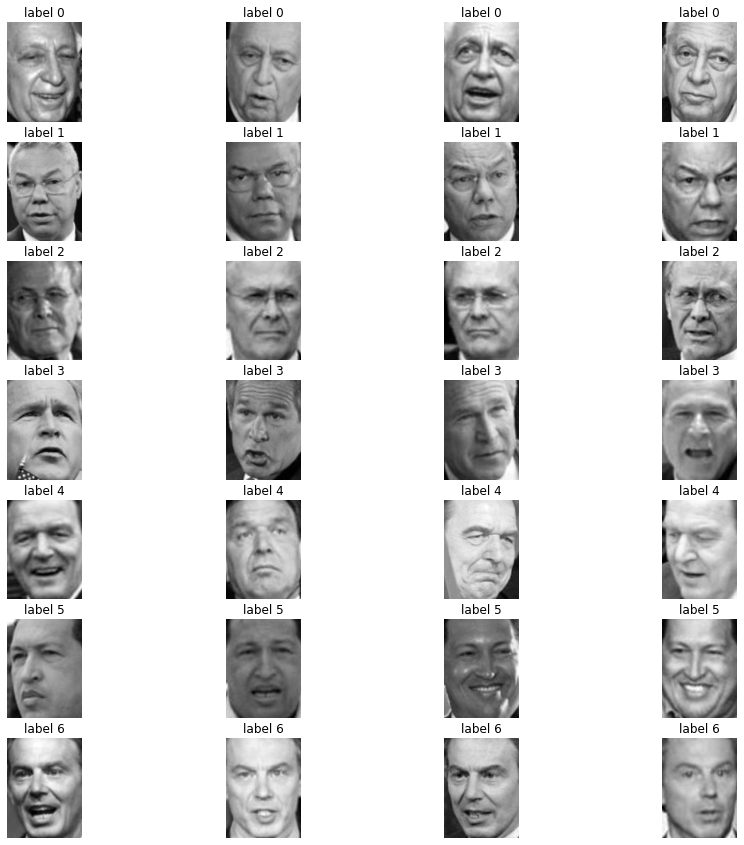

In [9]:
show_images(LFW_vis.images, LFW_vis.targets, figsize=(15, 15))

### 2. Création de $LFW test$ et $LFW val$, contenant 10 images de chaque identité 

In [10]:
# Creating treansforms object
transform0 = transforms.Compose([
          transforms.ToPILImage(),
          transforms.ToTensor(),
          transforms.Resize((100,100))])

In [11]:
LFW_test = LFW(min_faces_per_person=70, sub_set='test', transform=transform0)
LFW_test.get_info()
print(f'Image dimensions after resizing : {LFW_test[0][0].shape}')   

#------------- test datest -------------#
The number of images         : 70
The number of targets        : 70
The number of classes        : 7
The names of each individual : ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Image dimensions             : (70, 125, 94)
Image dimensions after resizing : torch.Size([1, 100, 100])


In [12]:
LFW_val = LFW(min_faces_per_person=70, sub_set='val', transform=transform0)
LFW_val.get_info()
print(f'Image dimensions after resizing : {LFW_val[0][0].shape}')

#------------- val datest -------------#
The number of images         : 70
The number of targets        : 70
The number of classes        : 7
The names of each individual : ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Image dimensions             : (70, 125, 94)
Image dimensions after resizing : torch.Size([1, 100, 100])


### 3. Créez un $LFW train$, en ajoutant une certaine augmentation aléatoire des données après les transformations précédentes.

In [14]:
transform1 = transforms.Compose([
                        transforms.ToPILImage(),
                        # transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(5),
                        transforms.GaussianBlur(3),
                        transforms.ColorJitter(),
                        transforms.ToTensor(),
                        transforms.Resize((100,100))])

In [15]:
LFW_train = LFW(min_faces_per_person=70, sub_set='train', transform=transform1)
LFW_train.get_info()
print(f'Image dimensions after resizing : {LFW_train[0][0].shape}')

#------------- train datest -------------#
The number of images         : 1148
The number of targets        : 1148
The number of classes        : 7
The names of each individual : ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Image dimensions             : (1148, 125, 94)
Image dimensions after resizing : torch.Size([1, 100, 100])


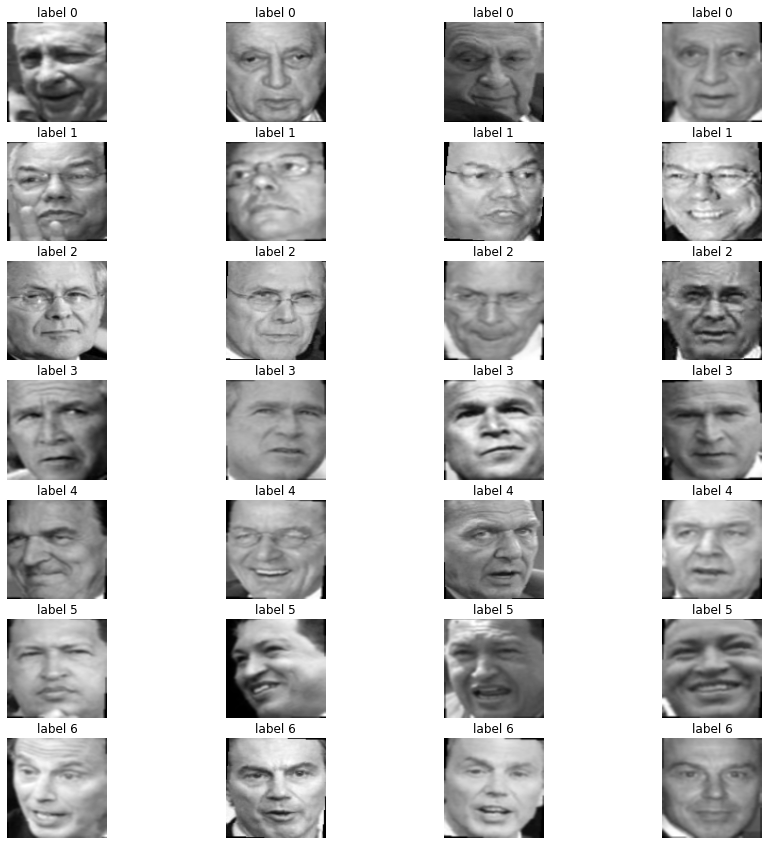

In [16]:
# Nomber images to show
nb_images = 28

# Extract images and labels from 'LFW_train' dataset
images  = [np.array(LFW_train[i][0].permute(1, 2, 0)).reshape(100, -1) for i in range(nb_images)]
targets = np.array([LFW_train[i][1] for i in range(nb_images)])

# Showing images after transforms
show_images(images, targets, nb_samples_of_each_individual=4, grid=False, figsize=(15, 15))

### 4. Création de $train dataloader$, en s'assurant qu'il est équilibré, c'est-à-dire que chaque classe est vue à peu près le même nombre de fois pendant une époque 

In [21]:
# Creating "train_dataloader", using DataLoader
class_sample_count = np.array([len(np.where(LFW_train.targets == t)[0]) for t in np.unique(LFW_train.targets)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in LFW_train.targets])
samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
train_dataloader = DataLoader(LFW_train, batch_size=128, sampler=sampler)


### 5. Dévelopement de la fonction $metrics$, prenant en entrée deux vecteurs $n$-dimensionnels $(y, y pred)$ (c'est-à-dire les étiquettes et les prédictions) et calculant la `précision`, `le rappel` et `la mesure f1_score`.

In [24]:
def metrics(y, y_pred):
  assert len(y) == len(y_pred)
  labels = sorted(np.unique(y))
  # Accuracy score.
  accuracy  = (y == y_pred).astype(int).sum()/len(y)
  # Precision score and recall score.
  precision = recall = f1_score = []
  for i, label in enumerate(labels) :
    precision.append((y[np.argwhere(y_pred==label)] == y_pred[np.argwhere(y_pred==label)]).astype(int).sum() / y_pred[np.argwhere(y_pred==label)].astype(int).sum())
    recall.append((y[np.argwhere(y_pred==label)] == y_pred[np.argwhere(y_pred==label)]).astype(int).sum() / y[np.argwhere(y==label)].astype(int).sum())
    f1_score.append(2 / (1/precision[-1] + 1/recall[-1]))
  return (accuracy, precision, recall, f1_score)


### 6. Entrainement des modèles `Resnet18` et `ConvNet`

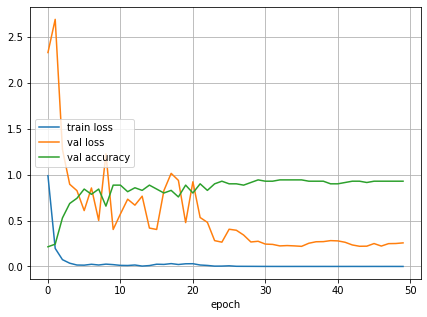

checkpoint generated from epoch 29, with val accuracy 0.9428571428571428


In [19]:
Loss = nn.CrossEntropyLoss()

best_checkpoint_resnet18 = train_loop( train_dataloader, val_data=LFW_val, Net=Resnet18, metrics=metrics, Loss=Loss, 
                              lr=0.0005,
                              n_epoch=50  )

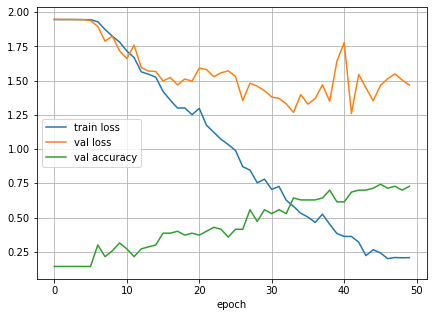

checkpoint generated from epoch 45, with val accuracy 0.7428571428571429


In [25]:
best_checkpoint_convNet = train_loop( train_dataloader, val_data=LFW_val, Net=ConvNet, metrics=metrics, Loss=Loss, 
                                      lr=0.0005,
                                      n_epoch=50  )

### 7. Evaluation des différents modèles 

In [27]:
# Extracting images and labels from 'LFW_test' dataset
images  = [LFW_test[i][0][None] for i in range(len(LFW_test.images))]
labels = [LFW_test[i][1] for i in range(len(LFW_test.targets))]
target_names = LFW_test.target_names

In [30]:
from sklearn.metrics import accuracy_score

models = {  'Resnet18': {'model':Resnet18(), 'best_checkpoint': best_checkpoint_resnet18},
            'ConvNet' : {'model': ConvNet(), 'best_checkpoint': best_checkpoint_convNet}  }

df = {'model' : ['ConvNet', 'Restnet18'], 
     'accuracy' : []}

for (key_models, value_models) in models.items():
  net = value_models['model']
  net.eval()
  net.load_state_dict(value_models['best_checkpoint'])
  # df['accuracy'].append(accuracy_score(labels, inference(net, image)))
  y_pred = [inference(net, image) for image in images]
  df['accuracy'].append(round(accuracy_score(labels, y_pred), 2))
  for label in  sorted(np.unique(np.array(labels))):
    _, precision, recall, f1_score_ = metrics((np.array(labels) == label).astype(int), (np.array(y_pred) == label).astype(int))
    key = f'class {label} pre./rec./f1'
    if (not key in df):
      df[key] = []
    df[key].append(f'{round(precision, 2)}/{round(recall, 2)}/{round(f1_score_, 2)}')



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
import pandas as pd
df = pd.DataFrame.from_dict(df)
df.head()

,model,accuracy,class 0 pre./rec./f1,class 1 pre./rec./f1,class 2 pre./rec./f1,class 3 pre./rec./f1,class 4 pre./rec./f1,class 5 pre./rec./f1,class 6 pre./rec./f1
0,ConvNet,0.99,1.0/1.0/1.0,1.0/1.0/1.0,1.0/1.0/1.0,1.0/1.0/1.0,0.99/0.99/0.99,1.0/1.0/1.0,0.99/0.99/0.99
1,Restnet18,0.69,0.89/0.89/0.89,0.84/0.84/0.84,0.99/0.99/0.99,0.89/0.89/0.89,0.94/0.94/0.94,0.94/0.94/0.94,0.89/0.89/0.89


### 8. Visualisation de quelques paires de tests (image, étiquette) avec le score associé (que le réseau produit).

In [32]:
from sklearn.metrics import accuracy_score

models = {  'Resnet18': {'model':Resnet18(), 'best_checkpoint': best_checkpoint_resnet18},
            'ConvNet' : {'model': ConvNet(), 'best_checkpoint': best_checkpoint_convNet}  }


for (key_models, value_models) in models.items():
  net = value_models['model']
  net.eval()
  net.load_state_dict(value_models['best_checkpoint'])
  y_pred = [inference(net, image) for image in images]
  print(f"The acuracy of the {key_models} model : {round(accuracy_score(labels, y_pred)*100, 2)}%")

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The acuracy of the Resnet18 model : 98.57%
The acuracy of the ConvNet model : 68.57%


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


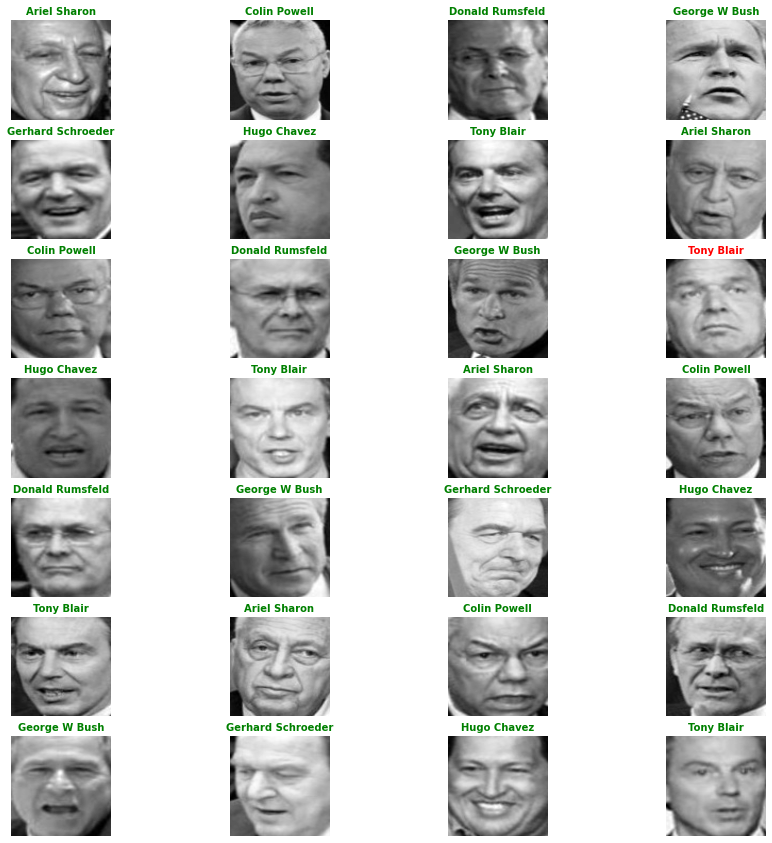

In [33]:
# Detection with Resbet18
show_images_and_pridiction(net=Resnet18, 
                           best_checkpoint=best_checkpoint_resnet18, 
                           images=images[:28], 
                           labels=labels, target_names=target_names,
                           inference=inference, total_cols=4, grid=False, figsize=(15, 15))

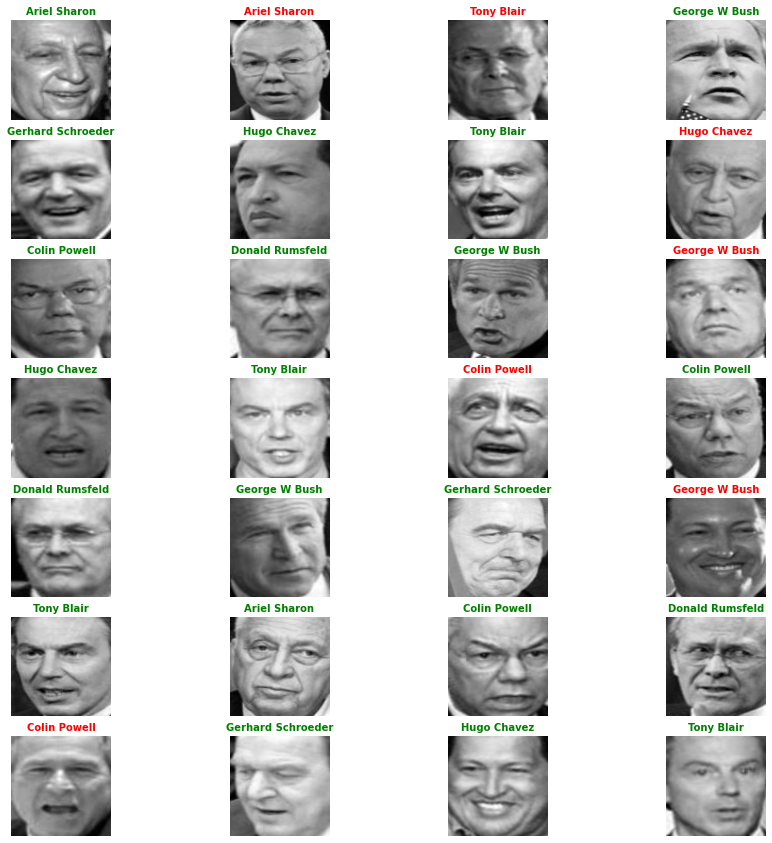

In [34]:
# Detection with ConvNet
show_images_and_pridiction(net=ConvNet, 
                           best_checkpoint=best_checkpoint_convNet, 
                           images=images[:28], 
                           labels=labels, target_names=target_names,
                           inference=inference, total_cols=4, grid=False, figsize=(15, 15))